# #6.4 Apply PhenoGraph on latent feature space

### 6.4.1 Perform clustering

In [ ]:
import pandas as pd
import sys

sys.path.append(r'../../modules/parametric_tsne/')
sys.path.append(r'../../modules/')
sys.path.append(r'../src/1_emr_scripts')

from DeterministicPhenoGraph import phenograph as phenograph2

from DeterministicPhenoGraph.phenograph.cluster import cluster as cluster2
import phenograph
import importlib as imp
import Visualization as func
from umap.parametric_umap import ParametricUMAP
import umap 
from sklearn.manifold import TSNE
import numpy as np
import pickle
import phenograph

# SET PARAMS
neighbours = 270 
SEED = 20221212 #9122022 # 

TECHNIQUE= 'MMAE'

# Load metadata
metadata = pd.read_csv('../new_data/5_clustering/df_metadata.csv')

# Load data
Z = pd.read_csv('../data/%s.csv' % EMBEDDING_SPACE) # maui_embedding_3.csv
Z = Z[Z.columns[4:]]

# Use default dim reduction techniques
fit1 = TSNE(random_state=SEED, n_components=2, perplexity=30, metric='minkowski').fit_transform(Z.values)
fit2 = umap.UMAP(random_state=SEED,metric='minkowski').fit(Z.values).embedding_ 

label, graph, Q  = cluster2(Z.values, k=neighbours, primary_metric='minkowski', n_jobs= 1, seed=SEED) # Do not know why it is seed + 1??

plt.scatter(fit1[:, 0], fit1[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);


# #6.5 Finetuning k from Phenograph 

Prior to applying phenograph it is important that you selected the optimal k

We will create a heatmap that depicts the similarity between iterations of Phenograph with different k's to select the most optimal k.

In [ ]:
from scipy import sparse
import numpy as np


# define a function that will give us the relevant output for the input k
def calc_cluster_characteristics(k, embedding, seed):
    results = pd.Series(dtype = 'float64')
    results['k'] = k 
    results['communities'], results['graph'], results['Q'] = phenograph.cluster(embedding, k=k, clustering_algo='louvain', seed=seed, primary_metric='minkowski') 
    results['components'], _ = sparse.csgraph.connected_components(results['graph'], directed = False)
    return results

seed=210721
ks = np.arange(10, 301, 10) # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k, Z.values, seed) for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

## #6.5.1 Q-modularity
Conclusion: based on this figure (and the continuous increment) we know this data is very homogenous and not really modular. Which is also what we observe on the T-SNE/ UMAP -> patients are laid out over a continuum rather than into modules.

read: https://github.com/dpeerlab/PhenoGraph/blob/master/examples/tutorial_pbmc3k.ipynb

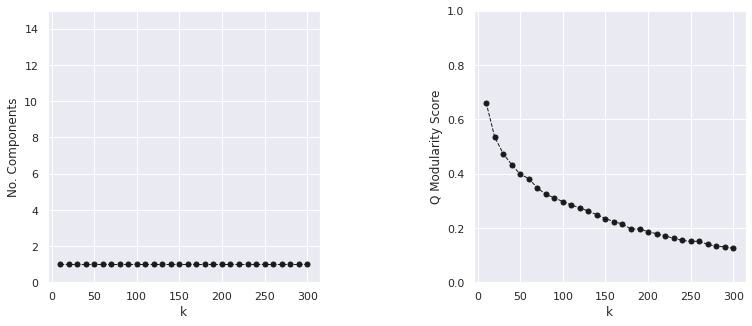

In [19]:
import matplotlib.pyplot as plt
k = cluster_characteristics['k']
no_components = cluster_characteristics['components']
Q = cluster_characteristics['Q']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_box_aspect(1)
ax1.plot(k, no_components, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5, )
ax1.set_xlabel('k')
ax1.set_ylabel('No. Components')
ax1.set_ylim(0, 15)

ax2.set_box_aspect(1)
ax2.plot(k, Q, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5)
ax2.set_xlabel('k')
ax2.set_ylabel('Q Modularity Score')
ax2.set_ylim(0, 1)

plt.show()
plt.close()

## #6.5.2 Rand Index (which K should we use?)

<ipython-input-20-dee34f6275e3>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


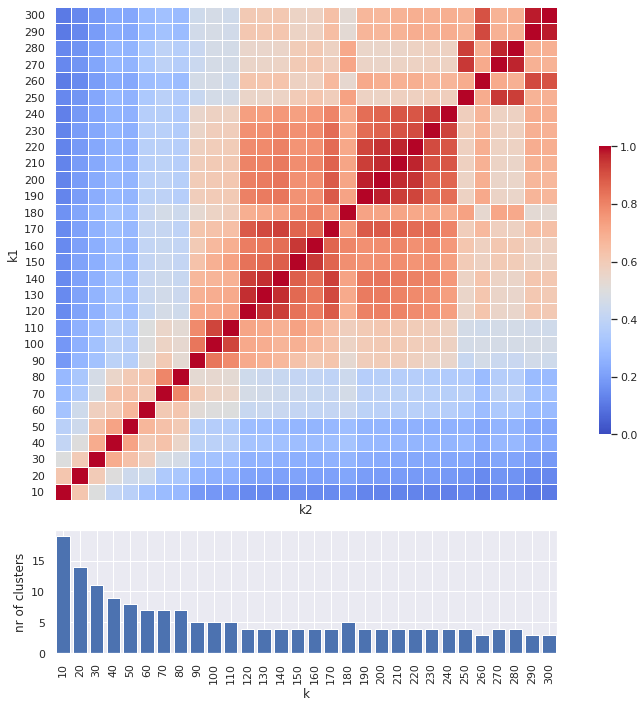

In [20]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
n = len(ks)
Rand_indices = pd.DataFrame(np.zeros((n,n)), index = ks, columns = ks)

Rand_indices.index.name = 'k1'
Rand_indices.columns.name = 'k2'

for i in range(n):
    for j in range(n):
        Rand_indices.iloc[i, j] = adjusted_rand_score(
            cluster_characteristics['communities'][i], 
            cluster_characteristics['communities'][j]
        )
        
cluster_characteristics['clusters'] = cluster_characteristics['communities'].apply(lambda x: len(np.unique(x)))



## Plot heatmap 
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), sharex='col',
                                                      gridspec_kw={'height_ratios': [16, 4]})
cbar_ax = fig.add_axes([1.05, .388, .02, .4]) 
sns.heatmap(Rand_indices, cmap=('coolwarm'), vmin=0, vmax=1, cbar_ax=cbar_ax, xticklabels=False, linewidths=1, ax=ax1).invert_yaxis()

ax2.set_xlabel('k')
ax2.set_ylabel('nr of clusters')

x_ticks = list(Rand_indices.columns)
x_tick_pos = [i + 0.5 for i in range(len(x_ticks))]
ax2.bar(x_tick_pos, cluster_characteristics['clusters'], align='center')
ax2.set_xticks(x_tick_pos)

ax2.set_xticklabels(x_ticks, rotation=90)

plt.tight_layout()
plt.show()

## #6.5.3 Robustness over multiple iterations
In less-structured data you would expect a lot of variety in the clustering over multiple iterations. Or data describing patients which lie on a continuum you might find more substantial changes between runs of the PhenoGraph algorithm. Hence, we show the cluster assignments over multiple runs of PhenoGraph, with unchanged parameter settings.

In [ ]:
import importlib as imp
imp.reload(phenograph)

k = 90 # k to use
n_runs = 5 # number of times to run PhenoGraph with unchanged parameters

cluster_cols = []

for i in range(n_runs):
    communities, graph, Q = phenograph.cluster(Z.values, k=k, clustering_algo='louvain', seed=20220202 , primary_metric='minkowski') #primary_metric='minkowski') # 
    cluster_name = 'PhenoGraph_k_' + str(k) + '_run_' + str(i)
    metadata[cluster_name] = pd.Categorical(communities)
    cluster_cols.append(cluster_name) 

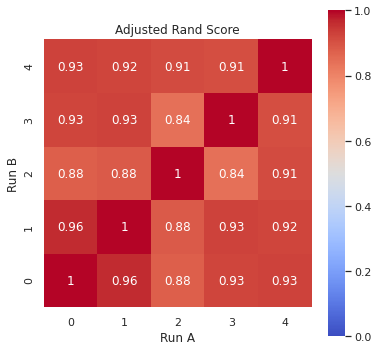

In [38]:
import numpy as np
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Rand_indices_unchanged_params = pd.DataFrame(np.zeros((n_runs,n_runs)))

for i in range(n_runs):
    for j in range(n_runs):
        Rand_indices_unchanged_params.iloc[i, j] = adjusted_rand_score(
            metadata[cluster_cols[i]], 
            metadata[cluster_cols[j]]
        )
        
plt.figure(figsize = (6,6))
sns.heatmap(Rand_indices_unchanged_params, cmap=('coolwarm'), square=True, vmin=0, vmax=1, annot = True).invert_yaxis()
sns.set(font_scale=1)
plt.xlabel('Run A')
plt.ylabel('Run B')
plt.title('Adjusted Rand Score')
plt.show()
plt.close()
